Федоров Антон

группа М8О-407Б-19

# AIDL: Курсовая работа

In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка и анализ данных

# Car Purchasing Data

In [2]:
data = pd.read_csv('Car_Purchasing_Data.csv')
data.head(10)

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248
5,Carla Hester,mi@Aliquamerat.edu,USA,1,57,68499.85162,14179.472440,428485.3604,56611.99784
6,Griffin Rivera,vehicula@at.co.uk,USA,1,47,39814.52200,5958.460188,326373.1812,28925.70549
7,Orli Casey,nunc.est.mollis@Suspendissetristiqueneque.co.uk,USA,1,50,51752.23445,10985.696560,629312.4041,47434.98265
8,Marny Obrien,Phasellus@sedsemegestas.org,USA,0,47,58139.25910,3440.823799,630059.0274,48013.61410
9,Rhonda Chavez,nec@nuncest.com,USA,1,43,53457.10132,12884.078680,476643.3544,38189.50601


Проверю, есть ли в данных nan-ы.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer Name        500 non-null    object 
 1   Customer e-mail      500 non-null    object 
 2   Country              500 non-null    object 
 3   Gender               500 non-null    int64  
 4   Age                  500 non-null    int64  
 5   Annual Salary        500 non-null    float64
 6   Credit Card Debt     500 non-null    float64
 7   Net Worth            500 non-null    float64
 8   Car Purchase Amount  500 non-null    float64
dtypes: float64(4), int64(2), object(3)
memory usage: 35.3+ KB


In [4]:
data.isnull().values.any()

False

Nan-ов нет, все объекты пригодны для обучения.

В данных есть признаки, которые не должны влиять на результаты предсказаний. Это имя клиента, их почта и страна(потому что из статистики на kaggle в этом датасете только клиенты из США). Удалю их.

In [5]:
data = data.drop(['Customer Name', 'Customer e-mail', 'Country'], axis=1)

Построю гистограммы признаков.

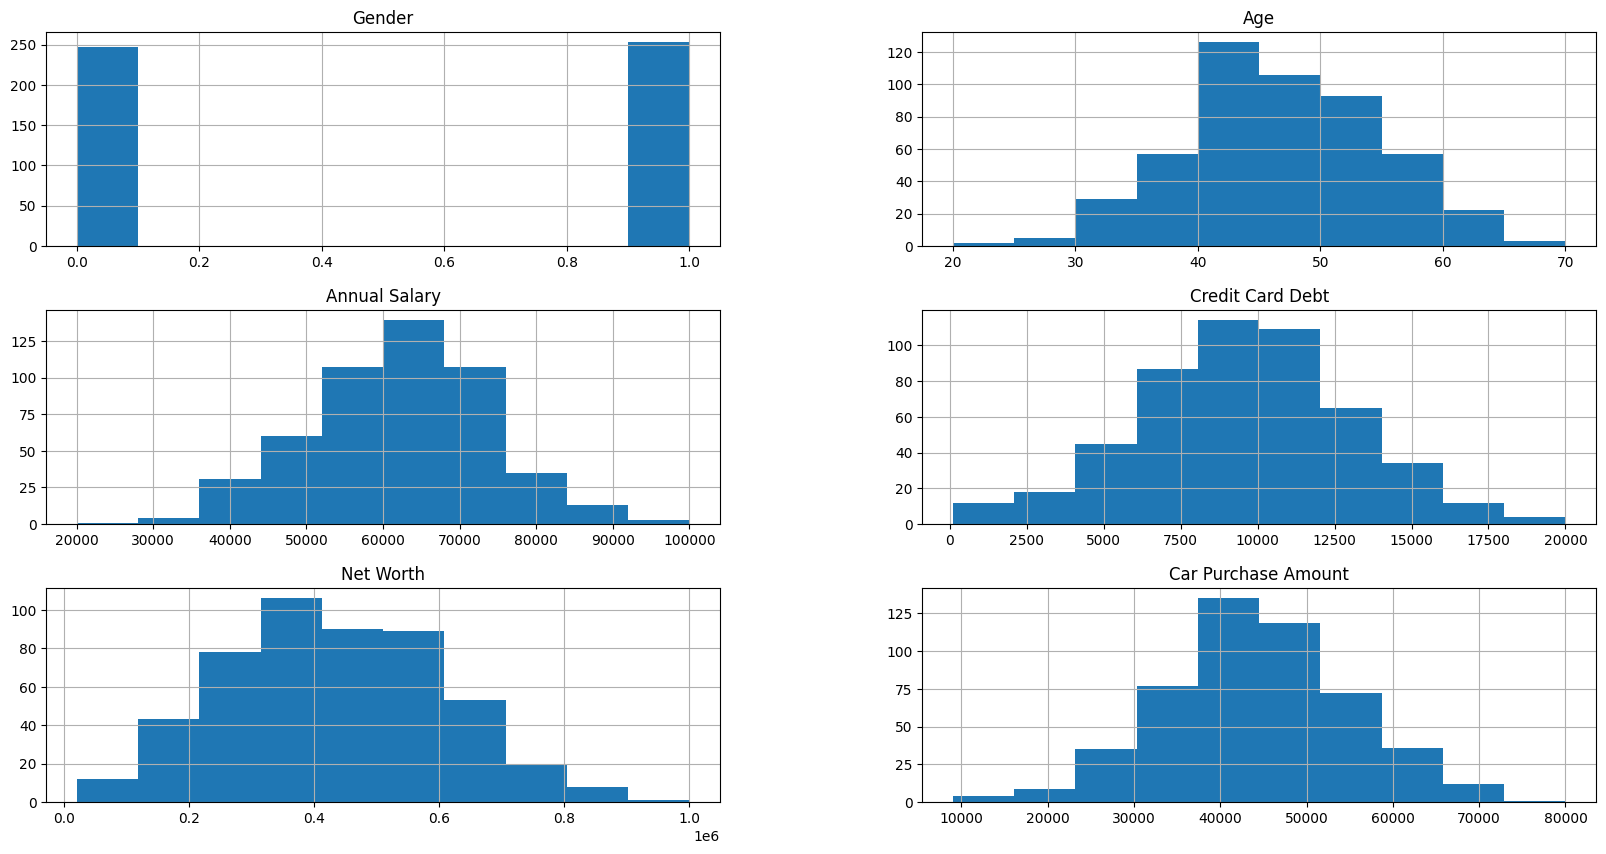

In [6]:
data.hist(column=data.columns, figsize=(20, 10))
None

<Figure size 1500x500 with 0 Axes>

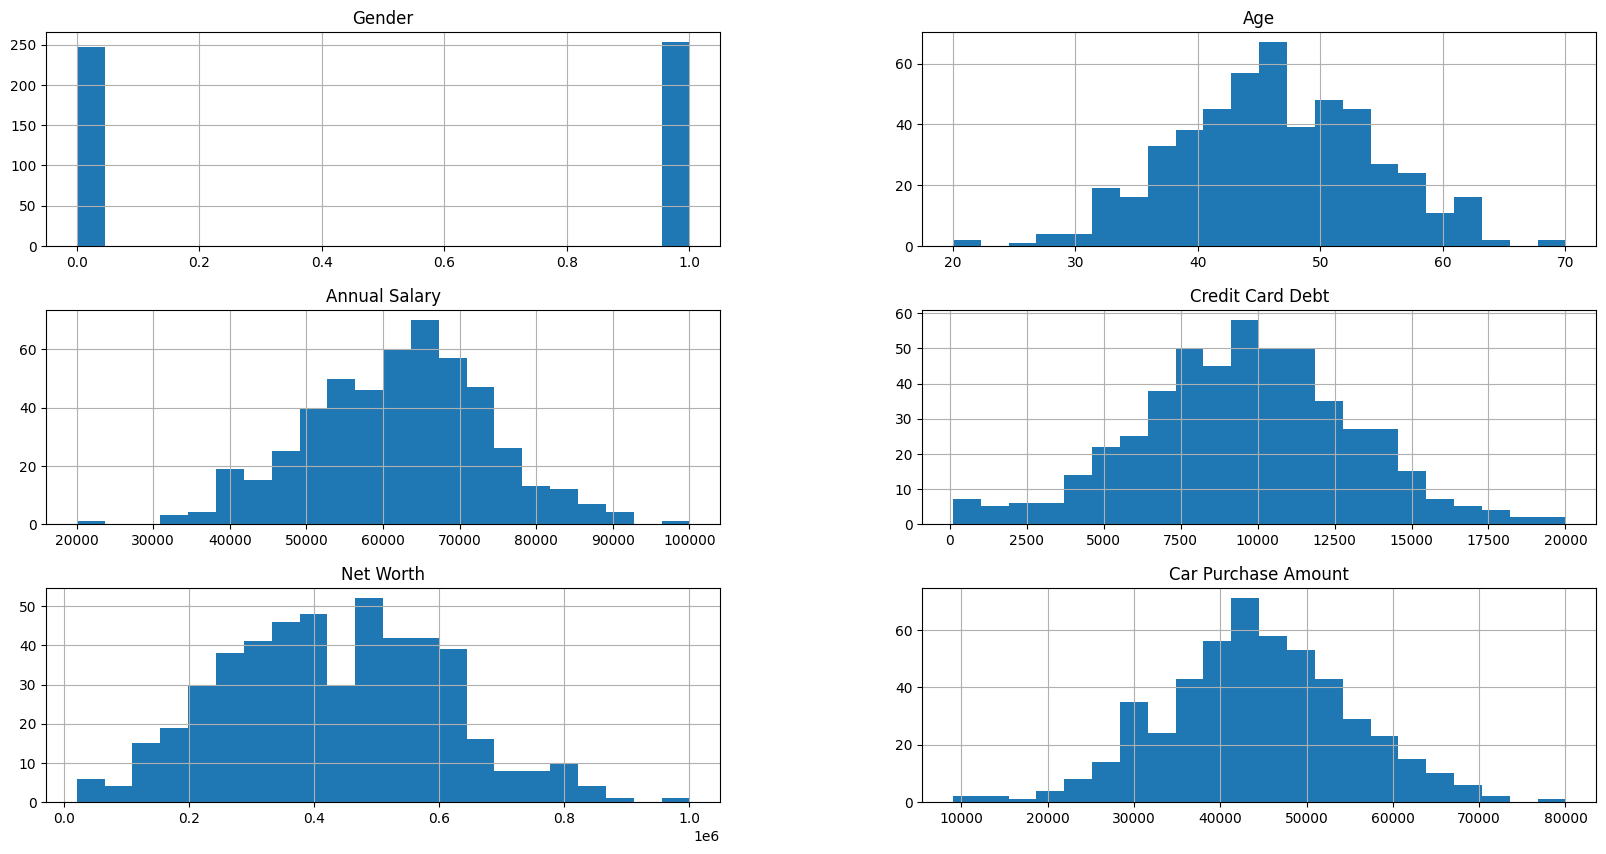

In [7]:
# Более мелкие слобцы
plt.figure(figsize=(15, 5))
binsNum = math.floor(math.sqrt(data.shape[0]))
data.hist(column=data.columns, bins=binsNum, figsize=(20, 10))
None

Взгляну на объекты датасета в плоскостях всех возможных парах признаков.

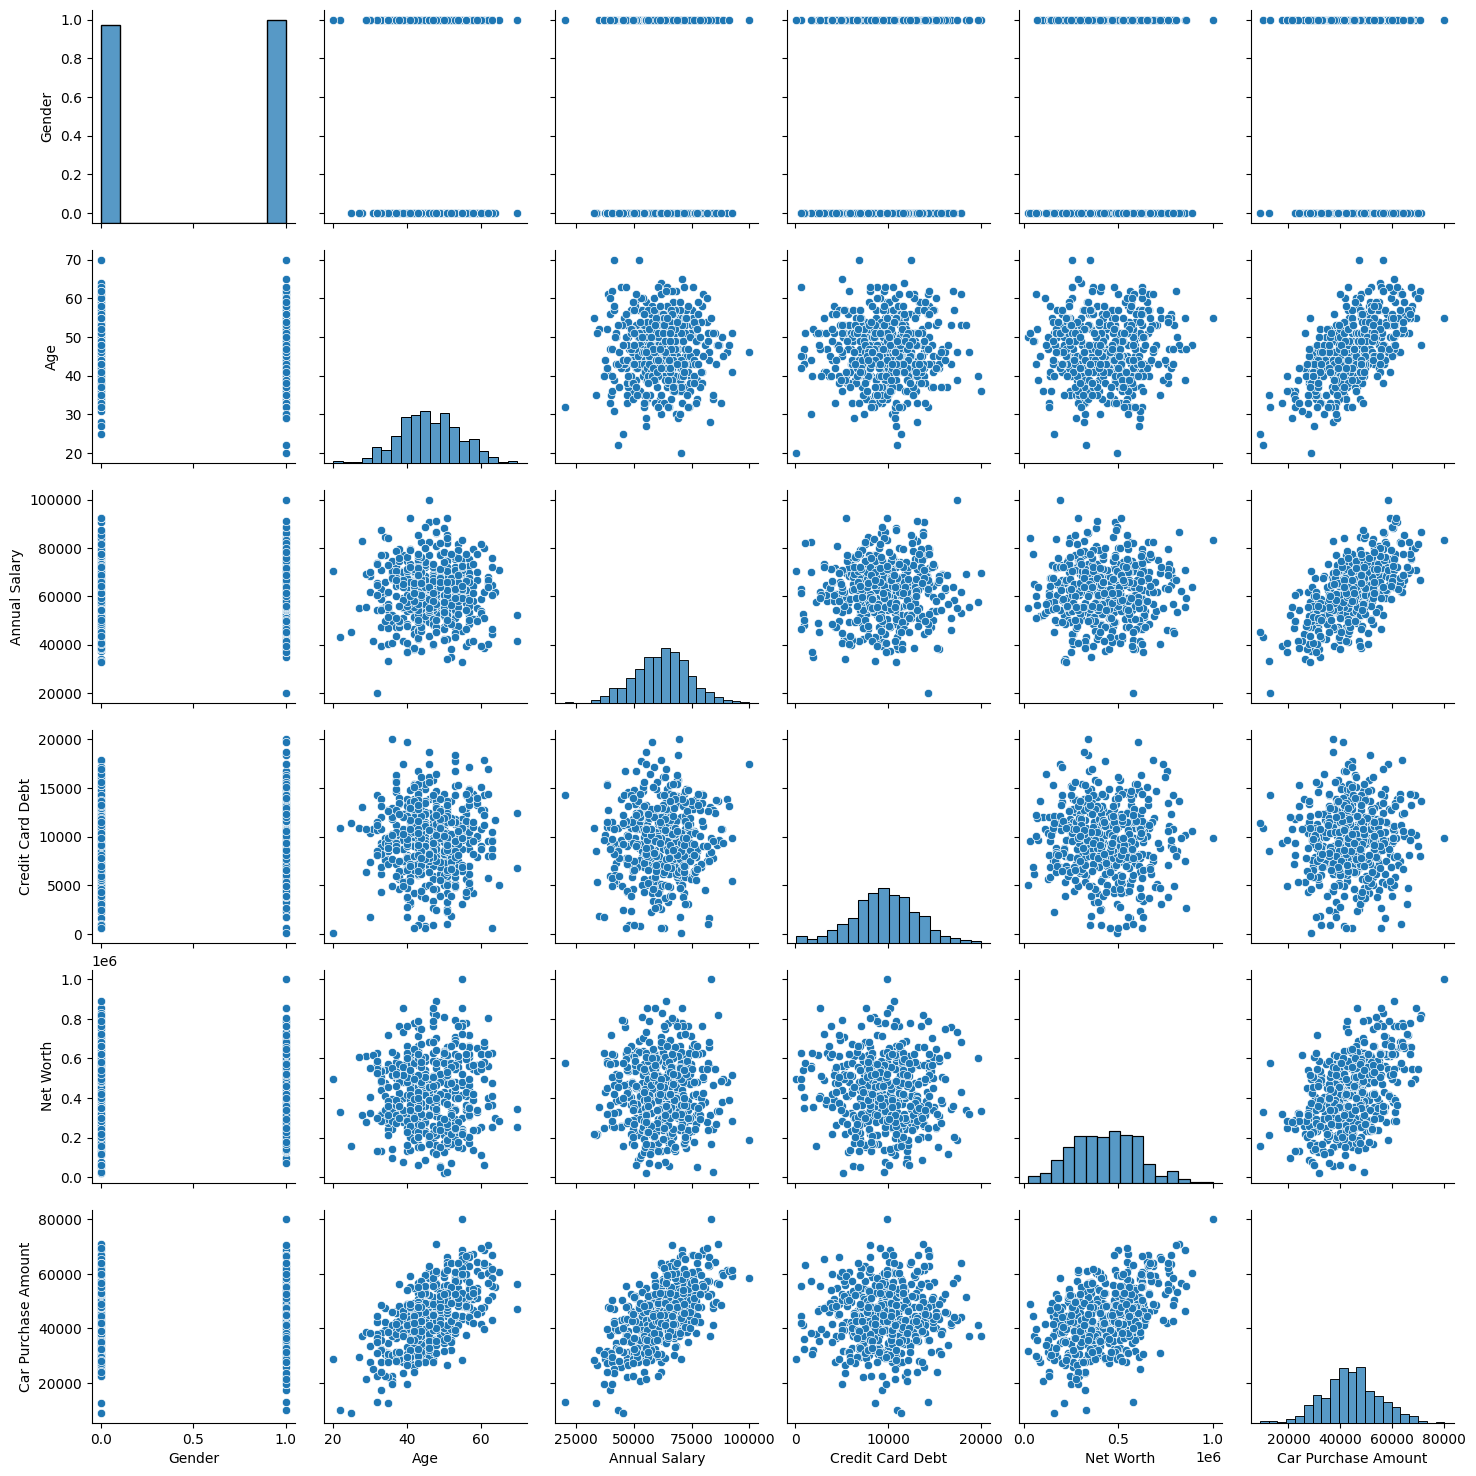

In [8]:
sns.pairplot(data=data)

Небольшие намеки на линейную зависимость есть для некоторых пар признаков, хороший знак.

Взгляну на матрицу корреляции.

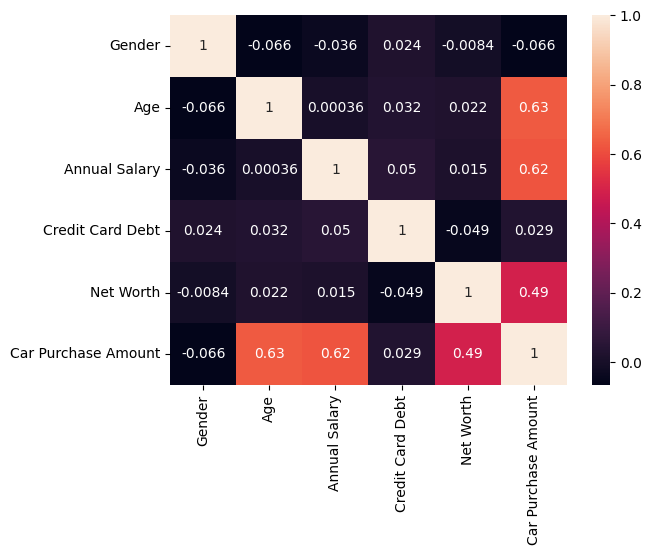

In [9]:
sns.heatmap(data.corr(), annot=True)
None

Корреляция между признаками невелика, хорошо, все признаки независимы. Есть относительно высокая корреляция возраста и годовой зарплаты с целевым признаком. Хорошо, так как явно прослеживается зависимость.

# Дерево решения для задачи регрессии

Реализую дерево решений для задачи регрессии и два критерия разбиения узлов.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin

def mse(y, estimation):
    return (1/len(y))*sum((y-estimation)**2)

def mae(y, estimation):
    return (1/len(y))*sum(y-estimation)

class Decision_node:
        def __init__(self):
            self.prediction = None
            self.Value = None
            self.Left = None
            self.Right = None

class Decision_tree(BaseEstimator, ClassifierMixin):
    def fit_node(self, node, X, Y, features, depth, min_leaf_size, criterion, estimation_type = 'mean'):
        x = X
        y = Y
        n = len(x)

        if estimation_type == 'mean':
            node.prediction = np.mean(y)
        if estimation_type == 'median':
            node.prediction = np.median(y)

        if depth == 1 or len(x) == 1 or len(x) == 0:
            return

        h = criterion(y, node.prediction)

        max_gain = -1
        left_ids = []
        right_ids = []
        for feature in features:
            sorted_Ids = x[:, feature].argsort()
            
            left_n = 0
            for i in range(n-1):
                left_n += 1
                
                left_y = y[sorted_Ids[:(i+1)]]
                right_y = y[sorted_Ids[(i+1):]]

                left_prediction = np.mean(left_y)
                right_prediction = np.mean(right_y)

                left_h = criterion(left_y, left_prediction)
                right_h = criterion(right_y, right_prediction)

                gain = h-(left_n*left_h+(n-left_n)*right_h)/n

                if gain > max_gain:
                    max_gain = gain
                    node.feature = feature
                    node.value = (x[sorted_Ids[i], feature]+x[sorted_Ids[i+1], feature])/2
                    left_ids = sorted_Ids[:i+1]
                    right_ids = sorted_Ids[i+1:]

        if len(left_ids) < min_leaf_size or len(right_ids) < min_leaf_size:
            return

        node.Left = Decision_node()
        node.Right = Decision_node()


        self.prediction = None
        self.fit_node(node.Left, x[left_ids], y[left_ids], features, depth-1, min_leaf_size, criterion, estimation_type)
        self.fit_node(node.Right, x[right_ids], y[right_ids], features, depth-1, min_leaf_size, criterion, estimation_type)

    def __init_(self):
        pass

    def fit(self, X, Y, features, depth, min_leaf_size, criterion, estimation_type):
        classes = len(np.unique(Y))
        self.root = Decision_node()
        self.fit_node(self.root, X, Y, features, depth, min_leaf_size, criterion, estimation_type)

    def predict(self, X):
        prediction = np.empty(X.shape[0])
        for i, object in enumerate(X):
            current_node = self.root
            while current_node.Left != None and current_node.Right != None:
                if object[current_node.feature] < current_node.value:
                    current_node = current_node.Left
                else:
                    current_node = current_node.Right
            prediction[i] = current_node.prediction
        return prediction

# Случайный лес для задачи регрессии

Реализую случайный лес для задачи регрессии. В предыдущей лабораторной работе, реализация случайного леса была примерно схожей, но для задачи классификации. Улучшу прошлую реализацию. Буду давать каждому отдельному дереву из и случайного леса случайно выбранную часть данных. Таким образом, каждое дерево будет обучено на различных подмножествах обучающей выборки, что позволит побороть переобучение и улучшить качетсво предсказаний на тестовой выборке. Величина подмножества задается параметром.

In [11]:
class Random_forest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators = 10, criterion = mse, max_depth = 20, min_samples_leaf = 2, estimation_type = 'mean', max_features = 'all', data_portion = 1.0, answer_assumption = 'median'):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.estimation_type = estimation_type
        self.max_features = max_features
        self.data_portion = data_portion
        self.answer_assumption = answer_assumption
    
    def fit(self, X, Y):
        features = np.arange(X.shape[1])
        
        self.forest = []
        for _ in range(self.n_estimators):
            np.random.shuffle(features)
            tree = Decision_tree()
            slice = int(self.data_portion*X.shape[0])-1
            portion_ids = np.random.permutation(X.shape[0])[:slice]

            if self.max_features == 'sqrt':
                tree.fit(X[portion_ids], Y[portion_ids], features[:int(np.floor(np.sqrt(len(features))))], self.max_depth, self.min_samples_leaf, self.criterion, self.estimation_type)
            if self.max_features == 'all':
                tree.fit(X[portion_ids], Y[portion_ids], features, self.max_depth, self.min_samples_leaf, self.criterion, self.estimation_type)
            self.forest.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.forest])
        if self.answer_assumption == 'median':
            forest_predictions = np.median(predictions, axis=0)
        if self.answer_assumption == 'mean': 
            forest_predictions = np.mean(predictions, axis=0)
        return forest_predictions

In [12]:
def plot_predictions(predictions, y_test):
    print("Max error:", sklearn.metrics.max_error(y_test, predictions))
    print("MAE:", sklearn.metrics.mean_absolute_error(y_test, predictions))
    print("MSE:", sklearn.metrics.mean_squared_error(y_test, predictions))
    print("R^2:", sklearn.metrics.r2_score(y_test, predictions))

    fig = plt.figure()
    plt.axis('equal')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.scatter(y_test, predictions, marker='o')
    plt.axline((0, 0), (1, 1), ls='--', c='grey')
    plt.show()

Разделю данные на обучающую и тестовую выборки.

In [13]:
import sklearn
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data.drop('Car Purchase Amount', axis=1).to_numpy(), 
                                                    data['Car Purchase Amount'].to_numpy(), 
                                                    train_size=0.8)

Попробую построить модель случайного леса с параметрами по умолчанию в качестве baseline-а.

Max error: 11809.728575000001
MAE: 2818.5079360435384
MSE: 13638113.728929207
R^2: 0.8601830414156021


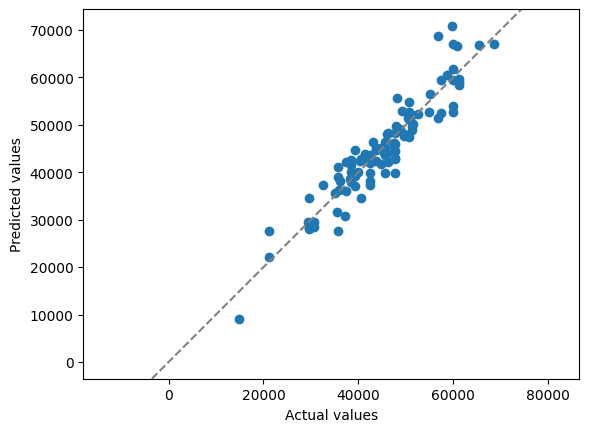

In [14]:
random_forest = Random_forest()
random_forest.fit(X_train, y_train)

predictions =  random_forest.predict(X_test)
plot_predictions(y_test, predictions)

Глядя на график, можно сказать, что модель уже способна в какой-то мере уловить закономерность. Попробую улучшить этот результат с помощью подбора гиперпараметров кросс-валидацией. Целевая метрика - MSE.

In [15]:
random_forest_regressor_cv = sklearn.model_selection.GridSearchCV(Random_forest(),
                                                                  {'n_estimators': [10, 25, 50],
                                                                   'criterion': [mse, mae],
                                                                   'max_depth': [5, 10, 15, 20],
                                                                   'min_samples_leaf': [1, 2, 3],
                                                                   'estimation_type': ['mean', 'median'],
                                                                   'max_features': ['sqrt', 'all'],
                                                                   'data_portion': [0.25, 0.50, 0.75, 1.0],
                                                                   'answer_assumption': ['mean', 'median']},
                                                                   scoring = 'neg_mean_squared_error',
                                                                   n_jobs=-1)

random_forest_regressor_cv.fit(X_train, y_train)
print(random_forest_regressor_cv.best_params_, random_forest_regressor_cv.best_score_, sep='\n')

{'answer_assumption': 'mean', 'criterion': <function mse at 0x7fb598691ea0>, 'data_portion': 0.75, 'estimation_type': 'median', 'max_depth': 20, 'max_features': 'all', 'min_samples_leaf': 1, 'n_estimators': 50}
-8972242.714534651


Судя по значениям гиперпараметров лучшей модели, чем больше деревьев, тем лучше. Взгляну на качество предсказаний на тестовой выборке.

Max error: 10012.816998400012
MAE: 1911.6664294499972
MSE: 7472130.436181851
R^2: 0.9160774191891411


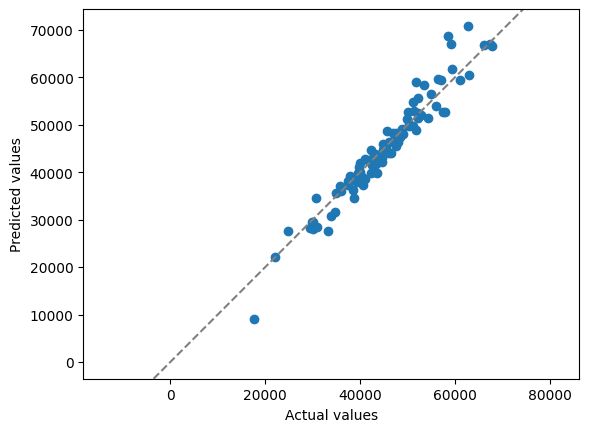

In [21]:
predictions =  random_forest_regressor_cv.predict(X_test)
plot_predictions(y_test, predictions)

Визуально стало значительно лучше, точки стали гораздо полее выстроенными вдоль линии. Все метрики тоже стали лучше.

Сравню качество своей реализации с реализацией из sklearn, оптимальные гиперпараметры также буду подбирать кросс-валидацией  с аналогичными наборами перебираемых значений, чтобы получиться наиболее качественную модель.

In [19]:
import sklearn.ensemble

In [20]:
sklearn_random_forest_regressor_cv = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestRegressor(n_jobs = -1),
                                                                            {'n_estimators': [10, 25, 50],
                                                                            'criterion': ['squared_error', 'absolute_error'],
                                                                            'max_depth': [5, 10, 15, 20],
                                                                            'min_samples_leaf': [1, 2, 3],
                                                                            'max_features': ['sqrt', 'log2', None]},
                                                                            scoring = 'neg_mean_squared_error',
                                                                            n_jobs = -1)
sklearn_random_forest_regressor_cv.fit(X_train, y_train)
print(sklearn_random_forest_regressor_cv.best_params_, sklearn_random_forest_regressor_cv.best_score_, sep='\n')

{'criterion': 'absolute_error', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}
-8014026.690774845


Взгляну на метрики и визуализацию предсказаний.

Max error: 9987.988681199997
MAE: 1838.4489051439994
MSE: 6480470.792447598
R^2: 0.9209183090528335


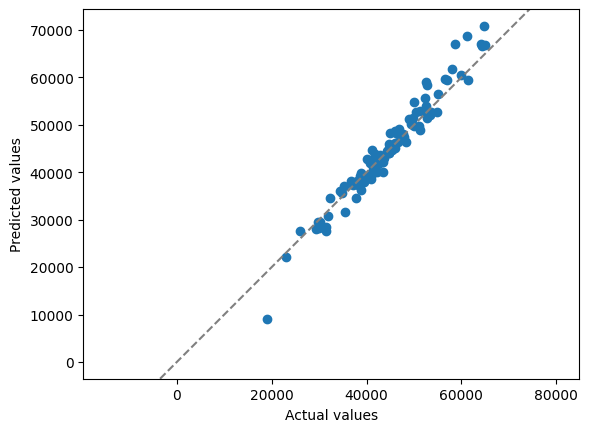

In [22]:
predictions =  sklearn_random_forest_regressor_cv.predict(X_test)
plot_predictions(y_test, predictions)

Результаты модели из sklearn оказались лучше, но не слишком сильно. Картина, в целом, схожая. Некоторые метрики отличаются совсем немного.

__Вывод__: В ходе выполнения курсового проекта был взят алгоритм случайного леса из лабораторной работы, улучшен добавлением возможности обучать деревья на случайных выборках из обучающих данных, а также адаптирован для задач регрессии. Результаты предсказаний оказались чуть хуже, чем у реализации того же самого алгоритма в sklearn. Возможно причиной может быть ситуация, когда некоторые объекты их обучающих данных ввиду случая не попали ни в одну выборку, на которой обучалось какое-либо дерево, что означает, что модель не учла полный объем информации для обучения.